# Rekonstruktion von Morse-Codes mithilfe von LSTM-Netwerken

Ziel dieses Projektes ist es, die Leerzeichen beziehungsweise die Pausen zwischen den Darstellungen einzelner Buchstaben im Morsecode mithilfe eines rekurrenten LSTM-Netzwerkes zu rekonstruieren. Obwohl durch das Weglassen der Leerzeichen im Prinzip Information verloren geht, ergeben meistens nur bestimmte Positionen der Leerzeichen sinnvolle Wörter.

In [ ]:
import tensorflow as tf
import numpy as np

## Morse-Kodierung

Zuerst schreiben wir eine Funktion `to_morse`, die ein Wort in Morse-Code übersetzt

In [2]:
morse_code = {
    'A': '.-',     'B': '-...',   'C': '-.-.',   'D': '-..',    'E': '.',      'F': '..-.',
    'G': '--.',    'H': '....',   'I': '..',     'J': '.---',   'K': '-.-',    'L': '.-..',
    'M': '--',     'N': '-.',     'O': '---',    'P': '.--.',   'Q': '--.-',   'R': '.-.',
    'S': '...',    'T': '-',      'U': '..-',    'V': '...-',   'W': '.--',    'X': '-..-',
    'Y': '-.--',   'Z': '--..' }

In [3]:
def to_morse_word(word):
    word = word.upper()
    if not all([x in morse_code for x in word]):
        raise Exception("Wort enthält Zeichen außerhalb des englischen Alphabets")
    return ' '.join([morse_code[x] for x in word])
def to_morse(phrase):
    return 'X'.join([to_morse_word(word) for word in phrase.split(" ")])

Test der Funktion:

In [4]:
to_morse("SOS V")

'... --- ...X...-'

## Eingabe und Ausgabe des neuronalen Netzwerkes

Wir müssen uns zuerst fragen, wie die Ein- und Ausgabe des Netzwerkes kodiert sein soll. Wie alle neuronalen Netze besteht die Eingabe eines LSTM-Modells nicht aus Zeichen, sondern aus Gleitkommazahlen.

Die Eingabe soll ein Morse-Code sein. Da die Leerzeichen weggelassen wurden, besteht dieser nur aus zwei Zeichen. Ein häufiges Verfahren für die Kodierung kategorischer Daten ist das *one-hot encoding*. Die folgende Funktion implementiert diese Codierung der Eingabe, wobei die Leerzeichen im Morsecode automatisch weggelassen werden.

**Look-ahead** Es ist schwierig für das neuronale Netz, zu entscheiden, wo die Morse-Codes unterbrochen werden sollen, ohne wenigstens ein paar Zeichen vorwärts schauen zu können. Daher verschiebe ich einfach Ein- und Ausgabe mithilfe eines einstellbaren look-aheads gegeneinander. Anders gesagt, das neuronale Netz muss erst einige Zeichen später signalisieren, dass ein Leerzeichen eingefügt werden soll.

In [5]:
lookahead = 10

Die Eingabe wird als `float`-Array kodiert, damit man sie direkt ins neuronale Netzwerk einspeisen kann.

In [6]:
def encode_input(morse):
    encodings = { '.': [1, 0, 0], '-': [0, 1, 0], 'X': [0, 0, 1] }
    return np.array([encodings[x] for x in (morse #+ lookahead*"X" 
                                           )if x != ' ']).astype(float)

In [7]:
encode_input(to_morse("SOS"))

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Die Ausgabe des Netzwerkes möchte ich so machen, dass das Netz für jedes Eingabezeichen entscheiden soll, ob nach diesem Zeichen ein Leerzeichen wahrscheinlich ist. Die gewünschte Ausgabe ist also `1`, wenn auf ein Zeichen im ursprünglichen Morsecode ein Leerzeichen folgt, und sonst `0`. Für das letzte Zeichen macht es Sinn, `1` vorzuschreiben, da das Wortende ja auch ein Buchstabenende ist. Die folgende Funktion implementiert die gewünschte Ausgabe:

In [8]:
def compute_target(morse):
    return np.array(#lookahead*[0] + 
        [int((b == " ") | (b == "X")) for a,b in zip(morse[:-1], morse[1:]) if a != " "] + [1]).astype(float)

In [9]:
compute_target(to_morse("HALLO I AM ALI"))

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.])

Bei "SOS" haben alle Buchstaben drei Zeichen, deshalb besteht die gewünscht Ausgabe aus drei gleichen Teilen.

## Trainings-Daten generieren

In [10]:
with open("bigdata set.txt", "r") as f:
    words = f.read()

In [ ]:
#Sicherstellen, dass alle Zeichen in "Words" Morsecode Zeichen oder Zeilenumrüche sind.
assert all([x.upper() in morse_code or x == "\n" for x in words])

In [12]:
# Teilt die Eingabezeichenkette "Words" in eine Liste von Wörtern auf, die in einzelnen Zeilen stehen
words = words.split("\n")[:-1]

In [13]:
# Definiert eine Funktion, die einen zufälligen Satz der angegebenen Länge aus den Wörtern in "Words" erstellt.
def get_random_phrase(length):
    phrase = ""
    while len(phrase) < length:
        if phrase != "":
            phrase += " "
        phrase += words[np.random.randint(len(words))]
    return phrase
# Erstellen von Trainingsdaten für das neuronale Netz, indem ein zufälliger Satz generiert wird, in einen Morsecode übersetzt und in geeignete Eingabe konvertiert wird.
def make_training_data(length):
    phrase = get_random_phrase(length)
    morse = to_morse(phrase)
    inputs = encode_input(morse)
    targets = compute_target(morse)
    inputs = inputs[:length]
    targets = targets[:length]
    return inputs, targets

In [14]:
get_random_phrase(50)

'snideness fremontia sweetful mykiss routine doublet'

In [15]:
# Funktion, die mehrere Chargen von Trainingsdaten erstellt, indem "make_training_data" für jede Charge aufgerufen wird.
def make_batches(n_batches, length):
    inputs, targets = [np.zeros((n_batches, length, k)) for k in [3,1]]
    for i in range(n_batches):
        inputs[i], targets[i,:,0] = make_training_data(length)
    return inputs, targets

In [16]:
morse_all = [to_morse(w) for w in words] # jedes Wort in words zu Morsecode konvertieren und in Morse_all speichern

In [17]:
np.amax([len(x) for x in morse_all]) #maximale Länge der Morsecode Darstellung eines Wortes in der Liste morse_all berechnen

31

In [18]:
# Erstellung von zwei leeren Arrays um die Eingabe und die Ausgabe des lstms zu speichern
words_all = np.zeros((len(words), 50 + lookahead, 3))
outs_all = np.zeros((len(words), 50 + lookahead, 1))

In [19]:
morse_all[1]

'.- --. . -. -.-. -.--'

In [20]:
# erstmal über jedes Wort in der Liste iterieren und dann das Morsecode-Äquivalent des aktuellen Wortes in der Variable c speichern. 
for i in range(len(words)):
    c = morse_all[i]
    print(len(c), encode_input(c).shape) # print die Länge des Morsecodes des Wortes und die Form des kodierten Eingabe Arrays, um die Größe der generierten Daten zu prüfen
    enc = encode_input(c) # c wird inein Eingabe Array konvertiert.
    outs_all[i,lookahead:lookahead+enc.shape[0],0] = compute_target(c) #Zielwerte für das neuronale Netzwerk im Array outs_all speichern
    words_all[i, :enc.shape[0]] = enc #  das kodierte Eingabe Array enc im words_all speichern
    words_all[i, enc.shape[0]:] = [0,0,1] # Rest des words_all auf 001 gesetzt um das der gültigen Daten im Array zu markieren.

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
27 (20, 3)
24 (18, 3)
27 (20, 3)
27 (20, 3)
25 (19, 3)
25 (19, 3)
21 (16, 3)
21 (15, 3)
27 (19, 3)
27 (20, 3)
23 (18, 3)
23 (18, 3)
21 (16, 3)
25 (19, 3)
24 (19, 3)
25 (19, 3)
26 (20, 3)
25 (19, 3)
21 (16, 3)
26 (20, 3)
25 (19, 3)
27 (20, 3)
21 (16, 3)
20 (16, 3)
22 (17, 3)
23 (17, 3)
27 (20, 3)
21 (15, 3)
26 (19, 3)
24 (18, 3)
26 (19, 3)
25 (18, 3)
16 (12, 3)
22 (16, 3)
28 (20, 3)
27 (20, 3)
20 (15, 3)
26 (19, 3)
27 (20, 3)
25 (18, 3)
24 (18, 3)
26 (19, 3)
20 (15, 3)
24 (18, 3)
22 (16, 3)
26 (19, 3)
25 (19, 3)
23 (17, 3)
26 (19, 3)
24 (18, 3)
25 (19, 3)
23 (18, 3)
20 (15, 3)
21 (16, 3)
23 (18, 3)
26 (20, 3)
20 (16, 3)
22 (16, 3)
28 (20, 3)
28 (20, 3)
27 (20, 3)
25 (17, 3)
27 (20, 3)
26 (20, 3)
21 (15, 3)
27 (19, 3)
26 (19, 3)
25 (19, 3)
21 (16, 3)
22 (16, 3)
26 (19, 3)
25 (19, 3)
24 (18, 3)
21 (16, 3)
21 (16, 3)
27 (20, 3)
25 (19, 3)
27 (20, 3)
27 (20, 3)
21 (16, 3)
22 (17, 3)
26 (20, 3)
23 (18, 3)
21 (16, 3)
25 (19, 3

In [21]:
words_all.shape, outs_all.shape

((71716, 60, 3), (71716, 60, 1))

## Trainings-Daten aus Text

In [22]:
with open("bigdata set.txt", "r") as f:
    text = f.read()
text = "".join([x for x in text if x == "\n" or x == " " or (x.upper() in morse_code)])
text = text.replace("\n", " ")
text = " ".join(text.split())

In [23]:
" ".join("abc def ghi".split())

'abc def ghi'

In [24]:
text[:500]

'activity agency ability actor actress agree aim air job able prep airline add airport addition alarm address album awful admire accent admit accept allow access advance accident advantage adventure advert advertise account advice advise ache adv achieve afford act ambition amount action age det page conj apply animal athlete ankle announce area annoy argue argument arm attach answer attack army attempt ant attend arrange attention arrest attitude arrival attract arrive art article audience artis'

In [25]:
def make_batch(length):  # Erstellt eine einzelne Trainingscharge, indem sie einen zufälligen Textabschnitt auswählt, diesen in Morsecode konvertiert und die Eingabe- und Zielarrays für das neuronale Netzwerk generiert.
    pos = np.random.randint(len(text) - length + 50)
    subtext = text[pos : pos + length + 50]
    idx = subtext[:50].find(" ")
    if idx > 0:
        subtext = subtext[idx : length + idx]
    morse = to_morse(subtext)
    inputs = encode_input(morse)
    targets = compute_target(morse)
    inputs = inputs[:length]
    targets = targets[:length]
    return inputs, targets

def make_batches(n_batches, length): # Erstellt mehrere Trainingschargen, indem sie make_batch wiederholt aufruft und die resultierenden Eingabe- und Zielarrays für alle Chargen sammelt.
    inputs, targets = [np.zeros((n_batches, length, k)) for k in [3,1]]
    for i in range(n_batches):
        inputs[i], targets[i,:,0] = make_batch(length)
    return inputs, targets

## Morse-Dekodieren zum Testen

In [26]:
morse_inverse = { code: letter for letter, code in morse_code.items() }

In [27]:
def morse_decode_word(with_spaces):
    codes = with_spaces.split(" ")
    return "".join([morse_inverse[x] if x in morse_inverse else "?" for x in codes])
def morse_decode(s):
    return " ".join([morse_decode_word(x) for x in s.split("X")])

In [28]:
def remove_spaces(s):
    return "".join([x for x in s if x != " "])

In [29]:
def insert_spaces(s_no_spaces, output=None):
    inp_encode = encode_input(s_no_spaces + lookahead*"X")
    if output is None:
        output = model(inp_encode.reshape(1,-1,3)).numpy()[0,:,0][lookahead:]
    with_spaces = ""
    for i in range(len(s_no_spaces)):
        char = s_no_spaces[i]
        with_spaces += char
        if output[i] > 0 and i < len(s_no_spaces) - 1 and s_no_spaces[i+1] != "X" and s_no_spaces[i] != "X":
            with_spaces += " "
    return with_spaces

In [30]:
len(words)

71716

## Definition und Training des Modells

In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(300, return_sequences=True))
#model.add(tf.keras.layers.Dense(150, activation='relu'))
#model.add(tf.keras.layers.LSTM(250, return_sequences=True))
#model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.LSTM(400, return_sequences=True))
model.add(tf.keras.layers.Dense(1000, activation='relu'))
#model.add(tf.keras.layers.Dense(2000, activation='relu'))
#model.add(tf.keras.layers.LSTM(60, return_sequences=True))
model.add(tf.keras.layers.Dense(1))

In [32]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])


STEP 1 / 15
Epoch 1/20
2242/2242 [==============================] - 47s 16ms/step - loss: 0.1725 - accuracy: 0.9035
Epoch 2/20
2242/2242 [==============================] - 35s 16ms/step - loss: 0.1803 - accuracy: 0.8981
Epoch 3/20
2242/2242 [==============================] - 36s 16ms/step - loss: 0.1720 - accuracy: 0.9026
Epoch 4/20
2242/2242 [==============================] - 36s 16ms/step - loss: 0.1769 - accuracy: 0.8990
Epoch 5/20
2242/2242 [==============================] - 36s 16ms/step - loss: 0.1611 - accuracy: 0.9102
Epoch 6/20
2242/2242 [==============================] - 36s 16ms/step - loss: 0.1552 - accuracy: 0.9131
Epoch 7/20
2242/2242 [==============================] - 37s 16ms/step - loss: 0.1547 - accuracy: 0.9133
Epoch 8/20
2242/2242 [==============================] - 37s 16ms/step - loss: 0.1632 - accuracy: 0.9087
Epoch 9/20
2242/2242 [==============================] - 37s 16ms/step - loss: 0.1724 - accuracy: 0.9042
Epoch 10/20
2242/2242 [=============================

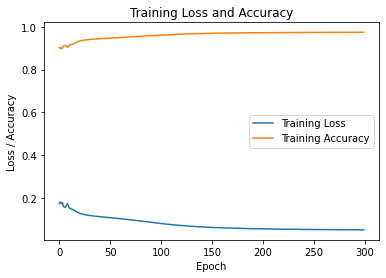

In [33]:
import matplotlib.pyplot as plt # um die Kurven zu plotten. 
#In diesem Codeabschnitt wird ein neuronales Netzwerkmodell trainiert, um Morsecode-Nachrichten zu übersetzen. Die Trainingsergebnisse werden gespeichert und anschließend visualisiert.
n_iter = 15
# Listen, um den Verlauf von Trainingsverlust und -genauigkeit zu speichern.
train_loss_history = []
train_acc_history = []
#For-Schleife über die Trainingsiterationen (n_iter):
#a. Drucke den aktuellen Schritt.
#b. Trainiere das Modell mit den Trainingsdaten (words_all und outs_all) für 20 Epochen und speichere den Verlauf.
#c. Aktualisiere die Listen train_loss_history und train_acc_history mit den neuesten Verlust- und Genauigkeitswerten.
#d. Teste das trainierte Modell, indem es 10 Wörter aus der Liste words in Morsecode übersetzt und die Ergebnisse ausgibt.

for i in range(n_iter): 
    print("STEP {} / {}".format(i+1, n_iter))
    history = model.fit(words_all, outs_all, epochs=20)
    train_loss_history += history.history['loss']
    train_acc_history += history.history['accuracy']
    
    for i in range(15, 25):
        word = words[i]
        rec = morse_decode(insert_spaces(remove_spaces(to_morse_word(word))))
        print(word, rec)
#Erstelle ein Diagramm zur Visualisierung des Trainingsverlaufs:
#a. Zeichne den Trainingsverlust und die Trainingsgenauigkeit.
#b. Beschrifte Achsen und füge eine Legende hinzu.
#c. Zeige das Diagramm.
plt.plot(train_loss_history, label='Training Loss')
plt.plot(train_acc_history, label='Training Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()


In [43]:
from tensorflow import keras

model.save('ModellBig.h5')


Hier werden die Accuracy und Loss genauer geplotet und gezeigt


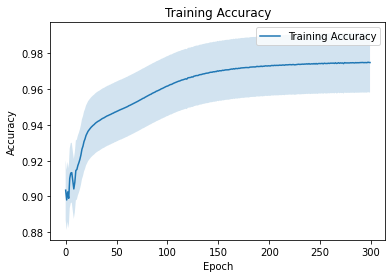

In [35]:
plt.plot(train_acc_history, label='Training Accuracy')
plt.fill_between(range(len(train_acc_history)), train_acc_history - np.std(train_acc_history), train_acc_history + np.std(train_acc_history), alpha=0.2)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


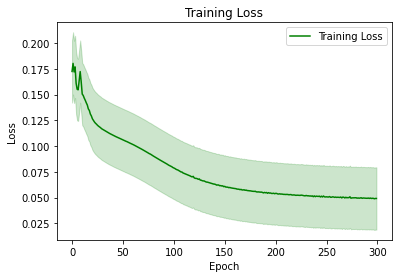

In [36]:
plt.plot(train_loss_history, color='green', label='Training Loss')
plt.fill_between(range(len(train_loss_history)), train_loss_history - np.std(train_loss_history), train_loss_history + np.std(train_loss_history), alpha=0.2, color='green')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [38]:
morse_orig = to_morse_word("cologne")
print(morse_orig)

-.-. --- .-.. --- --. -. .


In [39]:
nospace = remove_spaces(morse_orig)
print(nospace)

-.-.---.-..-----.-..


In [40]:
reconstructed = insert_spaces(nospace)
print(reconstructed)

-.-. --- .-.. --- --. -. .


In [41]:
morse_decode(reconstructed)

'COLOGNE'